In [1]:
# Import standard analytics packages.

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Import models 

from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

# Import scalers and metrics

from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings('ignore')

## Import data

In [2]:
df    = pd.read_csv('dataset_diabetes_diabetic_data.csv')
id_df = pd.read_csv('dataset_diabetes_IDs_mapping.csv')

In [3]:
df.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


## Data Cleaning

In [4]:
#df.isna().sum() 0 nans for all columns

In [4]:
df.columns

Index(['encounter_id', 'patient_nbr', 'race', 'gender', 'age', 'weight',
       'admission_type_id', 'discharge_disposition_id', 'admission_source_id',
       'time_in_hospital', 'payer_code', 'medical_specialty',
       'num_lab_procedures', 'num_procedures', 'num_medications',
       'number_outpatient', 'number_emergency', 'number_inpatient', 'diag_1',
       'diag_2', 'diag_3', 'number_diagnoses', 'max_glu_serum', 'A1Cresult',
       'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
       'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'examide', 'citoglipton', 'insulin',
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change', 'diabetesMed', 'readmitted'],
      dtype='object')

In [5]:
df.dtypes

encounter_id                 int64
patient_nbr                  int64
race                        object
gender                      object
age                         object
weight                      object
admission_type_id            int64
discharge_disposition_id     int64
admission_source_id          int64
time_in_hospital             int64
payer_code                  object
medical_specialty           object
num_lab_procedures           int64
num_procedures               int64
num_medications              int64
number_outpatient            int64
number_emergency             int64
number_inpatient             int64
diag_1                      object
diag_2                      object
diag_3                      object
number_diagnoses             int64
max_glu_serum               object
A1Cresult                   object
metformin                   object
repaglinide                 object
nateglinide                 object
chlorpropamide              object
glimepiride         

In [6]:
# drop these columns since they are missing a lot of entries.

df.drop(['encounter_id','patient_nbr','weight', 'payer_code', 'medical_specialty'],axis=1, inplace=True)

In [7]:
df.readmitted.replace({'NO': 0, '<30': 1, '>30': 2}, inplace=True)

In [8]:
# Select non-null entries after casting to numeric (V27,V57 and ? entries)

df = df[pd.to_numeric(df['diag_1'], errors='coerce').notnull()] # Select non-null values after changing values to
df = df[pd.to_numeric(df['diag_2'], errors='coerce').notnull()] # numeric (removing V27/V57 entries and ?)
df = df[pd.to_numeric(df['diag_3'], errors='coerce').notnull()] #

In [9]:
# Now, recast from string objects to float64 dtypes. (want to preserve ICD9 billing codes)

df.diag_1 = df.diag_1.astype('float64') # Can now recast from Object to Float64 dtypes (want float to preserve
df.diag_2 = df.diag_2.astype('float64') # ICD-9 decimals as part of the billing code)
df.diag_3 = df.diag_3.astype('float64') #

In [10]:
df.head()

,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
1,Caucasian,Female,[10-20),1,1,7,3,59,0,18,...,No,Up,No,No,No,No,No,Ch,Yes,2
3,Caucasian,Male,[30-40),1,1,7,2,44,1,16,...,No,Up,No,No,No,No,No,Ch,Yes,0
4,Caucasian,Male,[40-50),1,1,7,1,51,0,8,...,No,Steady,No,No,No,No,No,Ch,Yes,0
5,Caucasian,Male,[50-60),2,1,2,3,31,6,16,...,No,Steady,No,No,No,No,No,No,Yes,2
7,Caucasian,Male,[70-80),1,1,7,5,73,0,12,...,No,No,No,No,No,No,No,No,Yes,2


In [12]:
df.race.value_counts(normalize=True)

Caucasian          0.746592
AfricanAmerican    0.189963
?                  0.022451
Hispanic           0.019980
Other              0.014721
Asian              0.006293
Name: race, dtype: float64

In [13]:
df.race = np.where(df.race == '?', 'Other', df.race)

In [17]:
df.race.value_counts()

Caucasian          68570
AfricanAmerican    17447
Other               3414
Hispanic            1835
Asian                578
Name: race, dtype: int64

In [14]:
df.gender = np.where(df.gender == 'Unknown/Invalid', 'Female', df.gender)

In [18]:
df.columns

Index(['race', 'gender', 'age', 'admission_type_id',
       'discharge_disposition_id', 'admission_source_id', 'time_in_hospital',
       'num_lab_procedures', 'num_procedures', 'num_medications',
       'number_outpatient', 'number_emergency', 'number_inpatient', 'diag_1',
       'diag_2', 'diag_3', 'number_diagnoses', 'max_glu_serum', 'A1Cresult',
       'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
       'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'examide', 'citoglipton', 'insulin',
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change', 'diabetesMed', 'readmitted'],
      dtype='object')

In [19]:
df.dtypes

race                         object
gender                       object
age                          object
admission_type_id             int64
discharge_disposition_id      int64
admission_source_id           int64
time_in_hospital              int64
num_lab_procedures            int64
num_procedures                int64
num_medications               int64
number_outpatient             int64
number_emergency              int64
number_inpatient              int64
diag_1                      float64
diag_2                      float64
diag_3                      float64
number_diagnoses              int64
max_glu_serum                object
A1Cresult                    object
metformin                    object
repaglinide                  object
nateglinide                  object
chlorpropamide               object
glimepiride                  object
acetohexamide                object
glipizide                    object
glyburide                    object
tolbutamide                 

## EDA

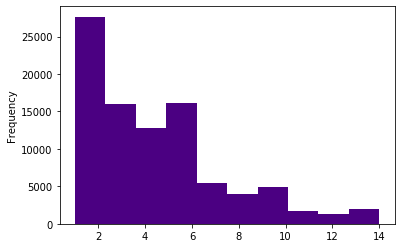

In [20]:
df.time_in_hospital.plot(kind='hist',color = 'indigo')

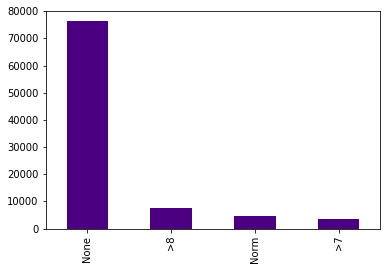

In [97]:
df.A1Cresult.value_counts().plot(kind='bar', color= 'indigo')

In [43]:
df.A1Cresult.value_counts()/len(df.A1Cresult)

None    0.832773
>8      0.080734
Norm    0.049034
>7      0.037458
Name: A1Cresult, dtype: float64

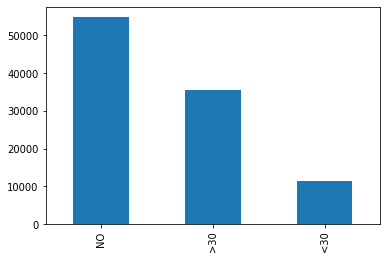

In [45]:
df.readmitted.value_counts().plot(kind='bar')

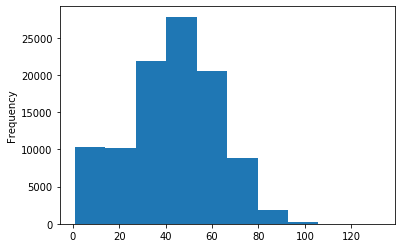

In [46]:
df.num_lab_procedures.plot(kind = 'hist')

In [61]:
df.gender.value_counts()

Female             54708
Male               47055
Unknown/Invalid        3
Name: gender, dtype: int64

3     17756
2     17224
1     14208
4     13924
5      9966
6      7539
7      5859
8      4391
9      3002
10     2342
11     1855
12     1448
13     1210
14     1042
Name: time_in_hospital, dtype: int64

In [64]:
df.groupby(['gender', 'time_in_hospital'])['time_in_hospital'].count()

gender           time_in_hospital
Female           1                   6917
                 2                   9064
                 3                   9606
                 4                   7702
                 5                   5488
                 6                   4274
                 7                   3232
                 8                   2414
                 9                   1663
                 10                  1290
                 11                  1035
                 12                   794
                 13                   651
                 14                   578
Male             1                   7289
                 2                   8160
                 3                   8150
                 4                   6222
                 5                   4478
                 6                   3265
                 7                   2627
                 8                   1976
                 9                   1339


In [67]:
gender_tih_prct = pd.DataFrame(df.groupby(by = 'gender')['time_in_hospital'].value_counts(normalize = True) * 100)

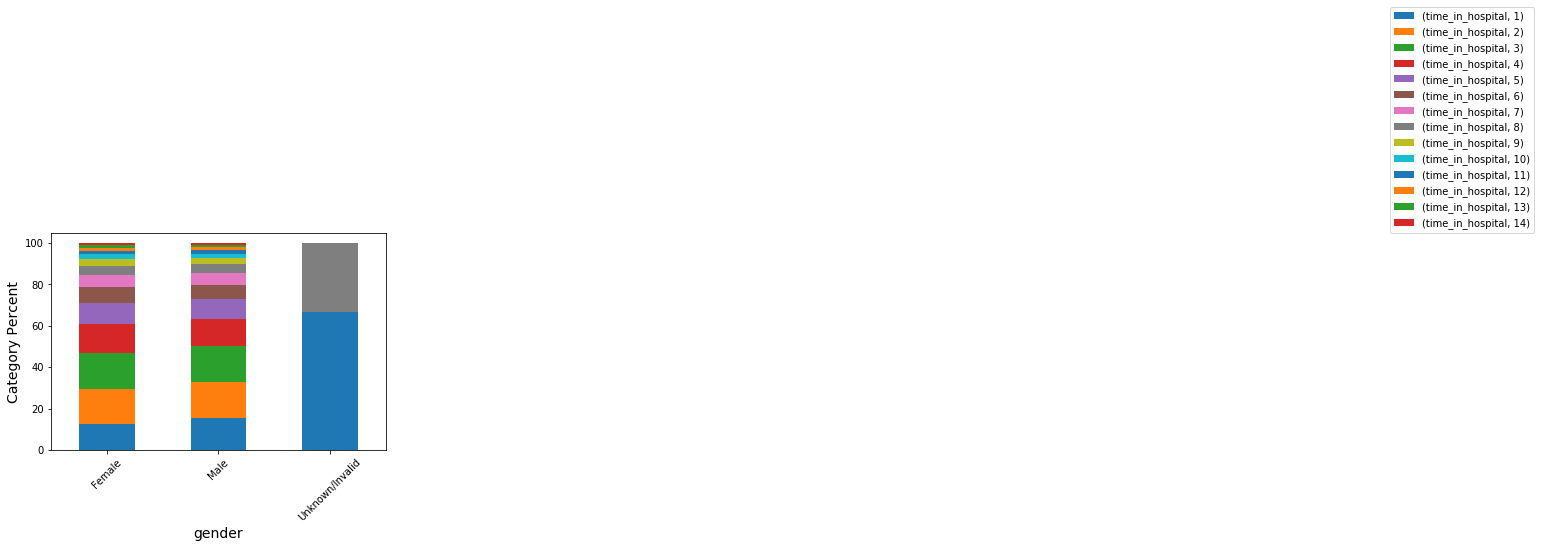

In [95]:
gender_tih_prct.unstack().plot(kind='bar', stacked=True)
plt.xlabel('gender', fontsize=14)
plt.ylabel('Category Percent',fontsize=14)
plt.xticks(rotation = 45)
plt.legend(loc = (4,1))                    ### work on legend formatting

In [78]:
df.dtypes

race                        object
gender                      object
age                         object
admission_type_id            int64
discharge_disposition_id     int64
admission_source_id          int64
time_in_hospital             int64
num_lab_procedures           int64
num_procedures               int64
num_medications              int64
number_outpatient            int64
number_emergency             int64
number_inpatient             int64
diag_1                      object
diag_2                      object
diag_3                      object
number_diagnoses             int64
max_glu_serum               object
A1Cresult                   object
metformin                   object
repaglinide                 object
nateglinide                 object
chlorpropamide              object
glimepiride                 object
acetohexamide               object
glipizide                   object
glyburide                   object
tolbutamide                 object
pioglitazone        

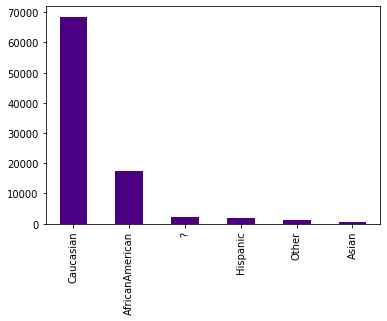

In [15]:
df.race.value_counts().plot(kind='bar', color='indigo')

In [107]:
# readmission rates based on gender.

df.groupby(['gender', 'readmitted'])['readmitted'].count()

gender  readmitted
Female  0             26168
        1              5546
        2             17763
Male    0             23128
        1              4715
        2             14524
Name: readmitted, dtype: int64

In [24]:
repl_dict = {0:'no readmission',
            1:'<30 days ',
            2:'>30 days'}

df['readd_cat'] = df['readmitted'].replace(repl_dict)
 

In [113]:
gender_prct = pd.DataFrame(df.groupby(by = 'gender')['readd_cat'].value_counts(normalize = True) * 100)
gender_prct

readd_cat
gender readd_cat                
Female no readmission  52.889221
       >30 days        35.901530
       <30 days        11.209249
Male   no readmission  54.589657
       >30 days        34.281398
       <30 days        11.128945

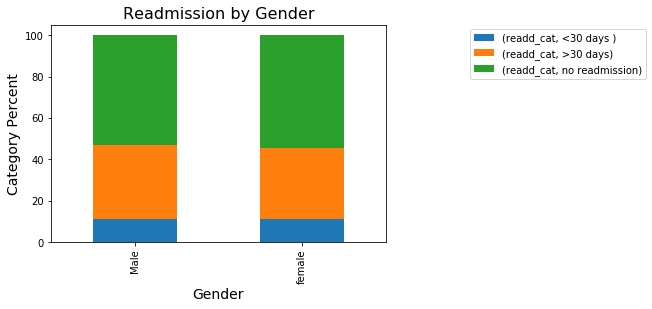

In [125]:
gender_prct.unstack().plot(kind='bar', stacked=True)
plt.xlabel('Gender', fontsize=14)
plt.xticks([0,1,],labels= ['Male', 'female'])
plt.ylabel('Category Percent',fontsize=14)
plt.title('Readmission by Gender', fontsize=16)
plt.legend(loc = (1.25,.75))

In [126]:
#readmission by age 

age_prct = pd.DataFrame(df.groupby(by = 'age')['readd_cat'].value_counts(normalize = True) * 100)
age_prct

readd_cat
age      readd_cat                
[0-10)   no readmission  78.571429
         >30 days        21.428571
[10-20)  no readmission  58.201058
         >30 days        35.978836
         <30 days         5.820106
[20-30)  no readmission  55.261166
         >30 days        31.264194
         <30 days        13.474640
[30-40)  no readmission  56.779920
         >30 days        32.047750
         <30 days        11.172329
[40-50)  no readmission  54.973459
         >30 days        34.133395
         <30 days        10.893146
[50-60)  no readmission  55.824868
         >30 days        34.537739
         <30 days         9.637392
[60-70)  no readmission  53.792968
         >30 days        35.217967
         <30 days        10.989065
[70-80)  no readmission  51.602861
         >30 days        36.516618
         <30 days        11.880522
[80-90)  no readmission  51.735255
         >30 days        36.215943
         <30 days        12.048802
[90-100) no readmission  60.305344
         >30 days        28.931298
         <30 days        10.763359

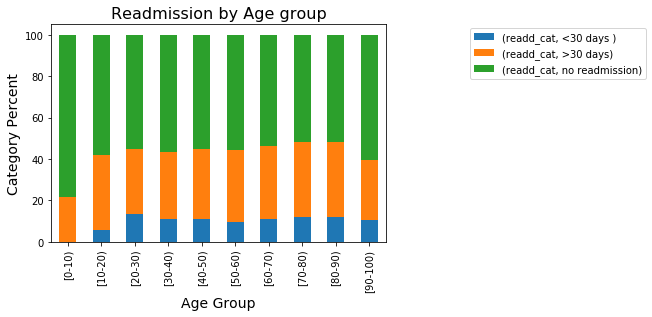

In [128]:
age_prct.unstack().plot(kind='bar', stacked=True)
plt.xlabel('Age Group', fontsize=14)

plt.ylabel('Category Percent',fontsize=14)
plt.title('Readmission by Age group', fontsize=16)
plt.legend(loc = (1.25,.75))

In [132]:
# readmission by race

race_prct = pd.DataFrame(df.groupby(by = 'race')['readd_cat'].value_counts(normalize = True) * 100)
race_prct

AttributeError: 'numpy.ndarray' object has no attribute 'groupby'

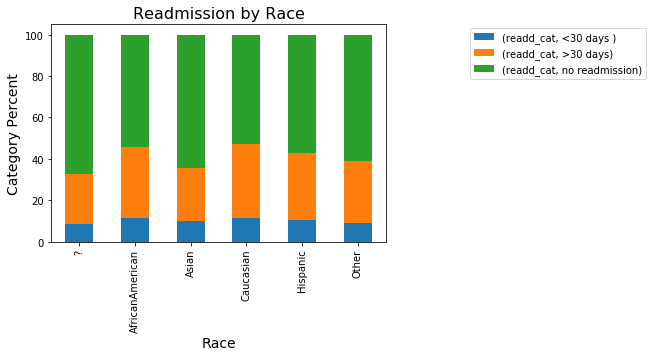

In [130]:
race_prct.unstack().plot(kind='bar', stacked=True)
plt.xlabel('Race', fontsize=14)

plt.ylabel('Category Percent',fontsize=14)
plt.title('Readmission by Race', fontsize=16)
plt.legend(loc = (1.25,.75))

In [131]:
df = np.where(df.race == '?', np.nan, df.race)

In [ ]:
df.groupby('time_in_hospital')['readmitted']

In [25]:
tih_prct = pd.DataFrame(df.groupby(by = 'time_in_hospital')['readd_cat'].value_counts(normalize = True) * 100)

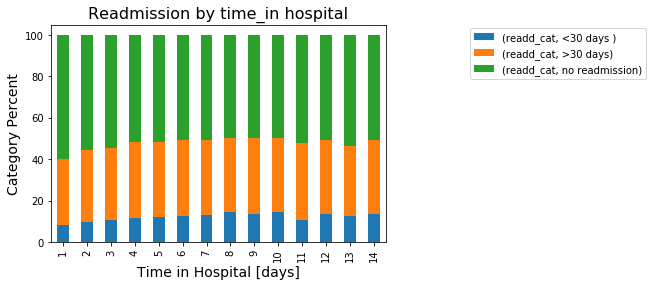

In [26]:
tih_prct.unstack().plot(kind='bar', stacked=True)
plt.xlabel('Time in Hospital [days]', fontsize=14)

plt.ylabel('Category Percent',fontsize=14)
plt.title('Readmission by time_in hospital', fontsize=16)
plt.legend(loc = (1.25,.75))